# Restaurant in Brooklyn - Which Neighborhoods should I pick to build a new one?

## 1. Introduction

Brooklyn, as one of the Borough in New York, is the most populous county and the second-most densely populated county in the United States, with an estimated 2,582,830 residents in 2018. This fact shows us that Brooklyn is a promising market for investors/business owners to start their business.

One of the challenge faced in starting new business is to choose where the location of the business is. As a Data Scientist, I am having an inquiry from a business owner to decide which neighborhoods are most suitable to build their first restaurant. 

The approach to solve the inquiry is to cluster all neighborhoods in Brooklyn based on criterias related to the problem. The criteria focuses on how many competitor is in the neighborhood, competitor's rating, and comments from customer about existing restaurants, and top venues in the neighborhood. The output would be different cluster of neighborhoods with different characteristics. The business owner then can choose in which cluster of neighborhoods should they build their first restaurant.

Hopefully this first restaurant will bring a lot of customers and generate enough revenue to leverage the business, that will help the company to expand to other locations.

## 2. Data

### 2.1. Data Sources

For this analysis, I make a list of neighborhoods in Brooklyn based on the New York Dataset provided by this course (https://cocl.us/new_york_dataset/). The data list 70 neighborhoods in Brooklyn. All of the Data used in this project will come from Foursquare Location Data, which focuses on Location Data and Venues Data. 

Location data are used to list venues that lies within the radius in the neighborhood. After listing all the venues, we explore all the venues by Venues Data to gather ratings and # of tips from every restaurant. We also list the top 10 venues that exist in each neighborhood. Finally, those neighborhood will be clustered using K-Means Clustering, to group similar neighborhoods with positive score in each aspect.

In [1]:
## import related libraries

import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

import folium # map rendering library

from urllib.request import urlopen
import json
from pandas.io.json import json_normalize

#import matplotlib plot modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

print('Libraries imported.')

Libraries imported.


### Neighborhood Data

In [2]:
# load the json
response = urlopen("https://cocl.us/new_york_dataset/")
json_data = response.read().decode('utf-8', 'replace')

newyork_data = json.loads(json_data)
newyork_data

neighborhoods_data = newyork_data['features']

# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

# build neighborhoods dataframe
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

# slice neighborhoods only in brooklyn
brooklyn_data = neighborhoods[neighborhoods['Borough'] == 'Brooklyn'].reset_index(drop=True)
brooklyn_data.head()

Borough Neighborhood   Latitude  Longitude
0  Brooklyn    Bay Ridge  40.625801 -74.030621
1  Brooklyn  Bensonhurst  40.611009 -73.995180
2  Brooklyn  Sunset Park  40.645103 -74.010316
3  Brooklyn   Greenpoint  40.730201 -73.954241
4  Brooklyn    Gravesend  40.595260 -73.973471

## 3. Methodology

This section represents the main component of the report where I discuss and describe any exploratory data analysis that I did, any inferential statistical testing that I performed, if any, and what machine learnings were used and why.

### 3.1. Exploratory Data Analysis

#### Map View

Let's view every neighborhood in Brooklyn with a map. First, we determine the coordinate of Brooklyn as the center of map. Then, we mark each neighborhood as a point in the map using homogenous markers.

In [3]:
# in case geolocator fails to fetch brooklyn coordinates
latitude = 40.650002
longitude = -73.949997

print('The geograpical coordinate of Brooklyn are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Brooklyn are 40.650002, -73.949997.


In [4]:
# create map of Brooklyn using latitude and longitude values
map_brooklyn = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, label in zip(brooklyn_data['Latitude'], brooklyn_data['Longitude'], brooklyn_data['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_brooklyn)  
    
map_brooklyn

### Nearby Venues Exploration

To determine nearby venues for each neighborhoods, we use the Foursquare Location Data to list all venues that lies nearby. First, we need to state the credentials needed for the Foursquare API.

In [5]:
CLIENT_ID = 'YRWPK2KD2FTXJK542M243ALZDXZQMI1BRE41L0A12GCWVZZ2' # my Foursquare ID
CLIENT_SECRET = 'XFPAUCH2XEF0M44IIUJNDJ3ZSWVKWZ25IFJX3IRHHZPHUZNN' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('My credentials:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

My credentials:
CLIENT_ID: YRWPK2KD2FTXJK542M243ALZDXZQMI1BRE41L0A12GCWVZZ2
CLIENT_SECRET:XFPAUCH2XEF0M44IIUJNDJ3ZSWVKWZ25IFJX3IRHHZPHUZNN


Next let's determine the radius (r) of which the venues will be counted to be in one neighborhood if it lies inside this radius. Let's assume that the business owner that ask our help wants to build a restaurant that is reachable by walking from the neighborhood center. From a simple google search, we found out that an acceptable walking distance is a 5-minute walk or 0.25 miles/402 meters (source: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3377942/)

We also only list 100 venues inside this radius, assuming that the number of venues in a neighborhood within the radius is <= 100.

First, let's explore the first neighborhood entry in the brooklyn_data dataframe.

In [6]:
firstnei = brooklyn_data.loc[0, 'Neighborhood']
print('The first neighborhood listed in the dataframe is: {}'.format(firstnei))

The first neighborhood listed in the dataframe is: Bay Ridge


In [7]:
neighborhood_latitude = brooklyn_data.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = brooklyn_data.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = brooklyn_data.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Bay Ridge are 40.625801065010656, -74.03062069353813.


In [8]:
radius = 402 # radius in meters
LIMIT = 100 # venues count limit
url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, radius, LIMIT)
url ## show sample venues url

'https://api.foursquare.com/v2/venues/explore?client_id=YRWPK2KD2FTXJK542M243ALZDXZQMI1BRE41L0A12GCWVZZ2&client_secret=XFPAUCH2XEF0M44IIUJNDJ3ZSWVKWZ25IFJX3IRHHZPHUZNN&ll=40.625801065010656,-74.03062069353813&v=20180605&radius=402&limit=100'

API REQUEST:

In [10]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e6b058b29ce6a001b527a12'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': '$-$$$$', 'key': 'price'},
    {'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Bay Ridge',
  'headerFullLocation': 'Bay Ridge, Brooklyn',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 55,
  'suggestedBounds': {'ne': {'lat': 40.62941906862866,
    'lng': -74.02586265372052},
   'sw': {'lat': 40.622183061392654, 'lng': -74.03537873335573}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b895827f964a5206c2d32e3',
       'name': 'Pilo Arts Day Spa and Salon',
       'location': {'address': '8412 3rd Ave',
        'lat': 40.62474788273414,
        'lng': -74.03059056940135,
        'labeledLat

Let's define a function that extracts the category of the venue from the json retrieved

In [11]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we list the venues retrieved from the data, only limiting to the features that we need in this analysis. We only need the name of the venue, its category, coordinate, distance from neighborhood center point, and its ID (to get each venues' rating and # of tips, more on that later)

In [12]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.id','venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng','venue.location.distance']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

id                         name      categories  \
0  4b895827f964a5206c2d32e3  Pilo Arts Day Spa and Salon             Spa   
1  4ad09cf7f964a520bed820e3                    Bagel Boy      Bagel Shop   
2  4a343f1ef964a520f69b1fe3          Leo's Casa Calamari     Pizza Place   
3  538ca7d5498ec684c6387a46                Cocoa Grinder       Juice Bar   
4  4abe4e84f964a520958c20e3                 Pegasus Cafe  Breakfast Spot   

         lat        lng  distance  
0  40.624748 -74.030591       117  
1  40.627896 -74.029335       257  
2  40.624200 -74.030931       180  
3  40.623967 -74.030863       205  
4  40.623168 -74.031186       296

In [13]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

55 venues were returned by Foursquare.


So that's how I get nearby venues of Bay Ridge. We only have done the nearby venues of 1 neighborhood. Meanwhile, Brooklyn is consist of dozens of neighborhoods. To get to know the number of neighborhoods in Brooklyn, let's get the length of brooklyn_data dataframe, that listed all neighborhoods in Brooklyn. 

In [14]:
print('There are {} neighborhoods in Brooklyn.'.format(brooklyn_data.shape[0]))

There are 70 neighborhoods in Brooklyn.


To get nearby venues from all 70 neighborhoods in Brooklyn, we need to loop the process to get nearby values from 1 neighborhood for all 70 of it. The idea is that to create a dataframe that will contain all of the nearby venues listed. We will call this dataframe 'bigbrooklyn_data'. The concept is to generate a small dataframe of nearby venues from each neighborhood and append it to the 'bigbrooklyn_data'. To differentiate each neighborhoods apart, I've added the 'neighborhood' column to 'bigbrooklyn_data' dataframe

In [ ]:
bigbrooklyn_data = pd.DataFrame(columns=['id', 'name', 'categories', 'lat', 'lng', 'neighborhood','distance'])

radius = 402
LIMIT = 100

for index in range(len(brooklyn_data)):
    neighborhood_latitude = brooklyn_data.loc[index, 'Latitude'] # neighborhood latitude value
    neighborhood_longitude = brooklyn_data.loc[index, 'Longitude'] # neighborhood longitude value

    neighborhood_name = brooklyn_data.loc[index, 'Neighborhood'] # neighborhood name

    #print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name,neighborhood_latitude,neighborhood_longitude))

    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, neighborhood_latitude, neighborhood_longitude, VERSION, radius, LIMIT)
    results = requests.get(url).json()
    
    venues = results['response']['groups'][0]['items']
    
    nearby_venues = json_normalize(venues) # flatten JSON

    # filter columns
    filtered_columns = ['venue.id','venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng','venue.location.distance']
    nearby_venues =nearby_venues.loc[:, filtered_columns]

    # filter the category for each row
    nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

    # clean columns
    nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
    nearby_venues["neighborhood"] = neighborhood_name
    
    # append
    bigbrooklyn_data = bigbrooklyn_data.append(nearby_venues, ignore_index=True)

Because the process takes a long time and eats up my API request limitation, I've written the dataframe in my local storage. The bigbrooklyn_data dataframe is as follows:

In [15]:
bigbrooklyn_data = pd.read_excel(r'D:\TELKOM\PEPRUS\2020\Coursera Applied Data Science Capstone\01-03-2020 11.42.11.xlsx')
bigbrooklyn_data.head()

categories  distance                        id        lat        lng  \
0             Spa       117  4b895827f964a5206c2d32e3  40.624748 -74.030591   
1      Bagel Shop       257  4ad09cf7f964a520bed820e3  40.627896 -74.029335   
2     Pizza Place       180  4a343f1ef964a520f69b1fe3  40.624200 -74.030931   
3       Juice Bar       205  538ca7d5498ec684c6387a46  40.623967 -74.030863   
4  Breakfast Spot       296  4abe4e84f964a520958c20e3  40.623168 -74.031186   

                          name neighborhood  
0  Pilo Arts Day Spa and Salon    Bay Ridge  
1                    Bagel Boy    Bay Ridge  
2          Leo's Casa Calamari    Bay Ridge  
3                Cocoa Grinder    Bay Ridge  
4                 Pegasus Cafe    Bay Ridge

Let's flag each restaurant with a new column: is_Restaurant. The value of the venue will be 1 if the venue category contains 'restaurant', and 0 otherwise.

In [16]:
df1 = bigbrooklyn_data[bigbrooklyn_data['categories'].str.contains('Restaurant')]
df1['is_Restaurant'] = 1
df2 = bigbrooklyn_data[~bigbrooklyn_data['categories'].str.contains('Restaurant')]
df2['is_Restaurant'] = 0

bigbrooklyn_data = df1.append(df2, ignore_index=True)
bigbrooklyn_data

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


categories  distance  \
0                         Caucasian Restaurant        43   
1                             Greek Restaurant       139   
2                    Middle Eastern Restaurant       374   
3                             Greek Restaurant       305   
4                           Chinese Restaurant        80   
5                           Italian Restaurant       327   
6                             Sushi Restaurant        75   
7                           Italian Restaurant       106   
8                           Italian Restaurant       112   
9                              Thai Restaurant       352   
10                          Mexican Restaurant       251   
11                          Seafood Restaurant       209   
12                          Italian Restaurant       331   
13                           Indian Restaurant       394   
14                          Dim Sum Restaurant       259   
15                          Italian Restaurant       251   
16                          Italian Restaurant       162   
17                          Chinese Restaurant       284   
18                          Italian Restaurant       248   
19                          Italian Restaurant       233   
20                          Russian Restaurant       142   
21                          Chinese Restaurant       232   
22                          Chinese Restaurant       250   
23                          Chinese Restaurant       258   
24                          Chinese Restaurant       381   
25                   Latin American Restaurant        18   
26                   Latin American Restaurant       260   
27                          Mexican Restaurant       372   
28                          Mexican Restaurant        82   
29                          Italian Restaurant       375   
30                           Polish Restaurant        72   
31                          Mexican Restaurant       105   
32                          Mexican Restaurant       145   
33                            Sushi Restaurant       186   
34                           French Restaurant       110   
35               Vegetarian / Vegan Restaurant        43   
36                          Italian Restaurant        75   
37                                  Restaurant       315   
38                       Vietnamese Restaurant       341   
39                     New American Restaurant       330   
40                             Thai Restaurant       240   
41                            Sushi Restaurant       162   
42                           French Restaurant       337   
43                          Mexican Restaurant       298   
44                          Falafel Restaurant       351   
45                            Sushi Restaurant       271   
46                           Indian Restaurant       352   
47                            Ramen Restaurant       401   
48                          Italian Restaurant       191   
49                          Italian Restaurant       238   
50                          Italian Restaurant       323   
51                                  Restaurant       182   
52                    Mediterranean Restaurant       205   
53                           Korean Restaurant       162   
54                 Eastern European Restaurant       331   
55                          Russian Restaurant       367   
56                            Sushi Restaurant        77   
57                            Sushi Restaurant       135   
58                                  Restaurant        26   
59                          Russian Restaurant       353   
60                        Fast Food Restaurant       378   
61                 Eastern European Restaurant       293   
62                 Eastern European Restaurant       259   
63                                  Restaurant       370   
64                          Russian Restaurant       283   
65                          Turkish Restaurant       356   
66              

The data that we had already is not complete yet. As I've mentioned earlier the data also need to include rating and # of tips for each venues. This data can be retrieved by using Foursquare Venue data, and loop them for each venue, by looping through the "ID" column. The code is as follows:

In [ ]:
#lets start the huge loop to get rating and number of tips from foursquare by exploring the venues one by one

for index in range(n,478):
    venue_id = bigbrooklyn_data.loc[index, 'id']
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(venue_id, CLIENT_ID, CLIENT_SECRET, VERSION)

    try: 
        result = requests.get(url).json()

        try:
            bigbrooklyn_data.loc[index, 'rating'] = result['response']['venue']['rating']
        except:
            bigbrooklyn_data.loc[index, 'rating'] = np.nan
        
        try:
            bigbrooklyn_data.loc[index, 'tips'] = result['response']['venue']['tips']['count']
        except:
            bigbrooklyn_data.loc[index, 'tips'] = np.nan
    except:
        bigbrooklyn_data.loc[index, 'rating'] = -1
        bigbrooklyn_data.loc[index, 'rating'] = -1
    
    n = n + 1

Because the process takes a long time and eats up my API request limitation, I've written the dataframe in my local storage. The new bigbrooklyn_data_rate dataframe is as follows:

In [17]:
bigbrooklyn_data_rate = pd.read_excel(r'D:\TELKOM\PEPRUS\2020\Coursera Applied Data Science Capstone\dummy rating tips data.xlsx')
bigbrooklyn_data_rate

categories  distance  \
0                         Caucasian Restaurant        43   
1                             Greek Restaurant       139   
2                    Middle Eastern Restaurant       374   
3                             Greek Restaurant       305   
4                           Chinese Restaurant        80   
5                           Italian Restaurant       327   
6                             Sushi Restaurant        75   
7                           Italian Restaurant       106   
8                           Italian Restaurant       112   
9                              Thai Restaurant       352   
10                          Mexican Restaurant       251   
11                          Seafood Restaurant       209   
12                          Italian Restaurant       331   
13                           Indian Restaurant       394   
14                          Dim Sum Restaurant       259   
15                          Italian Restaurant       251   
16                          Italian Restaurant       162   
17                          Chinese Restaurant       284   
18                          Italian Restaurant       248   
19                          Italian Restaurant       233   
20                          Russian Restaurant       142   
21                          Chinese Restaurant       232   
22                          Chinese Restaurant       250   
23                          Chinese Restaurant       258   
24                          Chinese Restaurant       381   
25                   Latin American Restaurant        18   
26                   Latin American Restaurant       260   
27                          Mexican Restaurant       372   
28                          Mexican Restaurant        82   
29                          Italian Restaurant       375   
30                           Polish Restaurant        72   
31                          Mexican Restaurant       105   
32                          Mexican Restaurant       145   
33                            Sushi Restaurant       186   
34                           French Restaurant       110   
35               Vegetarian / Vegan Restaurant        43   
36                          Italian Restaurant        75   
37                                  Restaurant       315   
38                       Vietnamese Restaurant       341   
39                     New American Restaurant       330   
40                             Thai Restaurant       240   
41                            Sushi Restaurant       162   
42                           French Restaurant       337   
43                          Mexican Restaurant       298   
44                          Falafel Restaurant       351   
45                            Sushi Restaurant       271   
46                           Indian Restaurant       352   
47                            Ramen Restaurant       401   
48                          Italian Restaurant       191   
49                          Italian Restaurant       238   
50                          Italian Restaurant       323   
51                                  Restaurant       182   
52                    Mediterranean Restaurant       205   
53                           Korean Restaurant       162   
54                 Eastern European Restaurant       331   
55                          Russian Restaurant       367   
56                            Sushi Restaurant        77   
57                            Sushi Restaurant       135   
58                                  Restaurant        26   
59                          Russian Restaurant       353   
60                        Fast Food Restaurant       378   
61                 Eastern European Restaurant       293   
62                 Eastern European Restaurant       259   
63                                  Restaurant       370   
64                          Russian Restaurant       283   
65                          Turkish Restaurant       356   
66              

Start one hot coding process to calculate ratio of venue category compared to all venues, for each neighborhood

In [18]:
#one hot coding
brooklyn_onehot = pd.get_dummies(bigbrooklyn_data_rate[['categories']], prefix="", prefix_sep="")
brooklyn_onehot['neighborhood'] = bigbrooklyn_data_rate['neighborhood']
fixed_columns = [brooklyn_onehot.columns[-1]] + list(brooklyn_onehot.columns[:-1])
brooklyn_onehot = brooklyn_onehot[fixed_columns]

#group by mean of frequency
brooklyn_grouped = brooklyn_onehot.groupby('neighborhood').mean().reset_index()
brooklyn_grouped

neighborhood  Accessories Store  Adult Boutique  \
0                  Bath Beach            0.00000            0.00   
1                   Bay Ridge            0.00000            0.00   
2          Bedford Stuyvesant            0.00000            0.00   
3                 Bensonhurst            0.00000            0.00   
4                Bergen Beach            0.00000            0.00   
5                 Boerum Hill            0.00000            0.00   
6                Borough Park            0.00000            0.00   
7              Brighton Beach            0.00000            0.00   
8           Broadway Junction            0.00000            0.00   
9            Brooklyn Heights            0.00000            0.00   
10                Brownsville            0.00000            0.00   
11                   Bushwick            0.00000            0.00   
12                   Canarsie            0.00000            0.00   
13            Carroll Gardens            0.00000            0.00   
14                  City Line            0.00000            0.00   
15               Clinton Hill            0.00000            0.00   
16                Cobble Hill            0.00000            0.00   
17               Coney Island            0.00000            0.00   
18              Crown Heights            0.00000            0.00   
19              Cypress Hills            0.00000            0.00   
20                Ditmas Park            0.00000            0.00   
21                   Downtown            0.00000            0.00   
22                      Dumbo            0.00000            0.00   
23              Dyker Heights            0.00000            0.00   
24              East Flatbush            0.00000            0.00   
25              East New York            0.00000            0.00   
26          East Williamsburg            0.00000            0.00   
27                    Erasmus            0.00000            0.00   
28                   Flatbush            0.00000            0.00   
29                  Flatlands            0.00000            0.00   
30                Fort Greene            0.00000            0.00   
31              Fort Hamilton            0.00000            0.00   
32               Fulton Ferry            0.00000            0.00   
33                 Georgetown            0.00000            0.00   
34            Gerritsen Beach            0.00000            0.00   
35                    Gowanus            0.00000            0.00   
36                  Gravesend            0.00000            0.00   
37                 Greenpoint            0.00000            0.00   
38              Highland Park            0.00000            0.00   
39                  Homecrest            0.00000            0.00   
40                 Kensington            0.00000            0.00   
41                    Madison            0.00000            0.00   
42            Manhattan Beach            0.00000            0.00   
43          Manhattan Terrace            0.00000            0.00   
44                Marine Park            0.00000            0.00   
45                    Midwood            0.00000            0.00   
46                 Mill Basin            0.00000            0.00   
47                Mill Island            0.00000            0.00   
48                   New Lots            0.00000            0.00   
49                 North Side            0.01000            0.01   
50                 Ocean Hill            0.00000            0.00   
51              Ocean Parkway            0.00000            0.00   
52            Paerdegat Basin            0.00000            0.00   
53                 Park Slope            0.02439            0.00   
54           Prospect Heights            0.00000            0.00   
55  Prospect Lefferts Gardens            0.00000            0.00   
56        Prospect Park South            0.00000            0.00   
57                   Red Hook            0.00000            0.00   
58   

Create brooklyn_grouped_sorted dataframe, that list top 10 most common venues per neighborhood and make it as columns 

In [19]:
#sort with venues categories for each postcode
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

#def function for sorting the most common venues
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False) 
    return row_categories_sorted.index.values[0:num_top_venues]

# create a new DF with columns according to number of top venues
columns = ['neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

brooklyn_grouped_sorted = pd.DataFrame(columns=columns)
brooklyn_grouped_sorted['neighborhood'] = brooklyn_grouped['neighborhood']

for ind in range(brooklyn_grouped.shape[0]):
    brooklyn_grouped_sorted.iloc[ind, 1:] = return_most_common_venues(brooklyn_grouped.iloc[ind, :], num_top_venues)

brooklyn_grouped_sorted

neighborhood 1st Most Common Venue   2nd Most Common Venue  \
0                  Bath Beach           Pizza Place                Pharmacy   
1                   Bay Ridge    Italian Restaurant                     Spa   
2          Bedford Stuyvesant           Coffee Shop  Thrift / Vintage Store   
3                 Bensonhurst    Chinese Restaurant      Italian Restaurant   
4                Bergen Beach            Donut Shop      Athletics & Sports   
5                 Boerum Hill                   Bar  Furniture / Home Store   
6                Borough Park                  Bank              Restaurant   
7              Brighton Beach    Russian Restaurant              Restaurant   
8           Broadway Junction        Sandwich Place            Burger Joint   
9            Brooklyn Heights         Deli / Bodega             Yoga Studio   
10                Brownsville            Restaurant                    Park   
11                   Bushwick                   Bar             Coffee Shop   
12                   Canarsie    Chinese Restaurant             Music Venue   
13            Carroll Gardens    Italian Restaurant             Coffee Shop   
14                  City Line     Mobile Phone Shop           Grocery Store   
15               Clinton Hill    Mexican Restaurant              Restaurant   
16                Cobble Hill            Playground             Coffee Shop   
17               Coney Island      Baseball Stadium            Skating Rink   
18              Crown Heights           Pizza Place              Bagel Shop   
19              Cypress Hills   Fried Chicken Joint    Fast Food Restaurant   
20                Ditmas Park         Deli / Bodega                Pharmacy   
21                   Downtown           Coffee Shop            Burger Joint   
22                      Dumbo                  Park             Coffee Shop   
23              Dyker Heights               Dog Run      Mexican Restaurant   
24              East Flatbush      Department Store          Hardware Store   
25              East New York         Deli / Bodega      Chinese Restaurant   
26          East Williamsburg                   Bar           Deli / Bodega   
27                    Erasmus  Caribbean Restaurant           Grocery Store   
28                   Flatbush    Mexican Restaurant               Juice Bar   
29                  Flatlands              Pharmacy     Fried Chicken Joint   
30                Fort Greene    Italian Restaurant             Pizza Place   
31              Fort Hamilton                  Bank      Italian Restaurant   
32               Fulton Ferry                  Park           Boat or Ferry   
33                 Georgetown                  Bank                Pharmacy   
34            Gerritsen Beach           Gas Station         Harbor / Marina   
35                    Gowanus  Gym / Fitness Center             Art Gallery   
36                  Gravesend           Pizza Place      Italian Restaurant   
37                 Greenpoint                   Bar            Cocktail Bar   
38              Highland Park         Grocery Store           Big Box Store   
39                  Homecrest                  Bank                Pharmacy   
40                 Kensington         Grocery Store                Pharmacy   
41                    Madison           Bus Station           Historic Site   
42            Manhattan Beach              Bus Stop              Playground   
43          Manhattan Terrace     Convenience Store          Ice Cream Shop   
44                Marine Park         Deli / Bodega          Cosmetics Shop   
45                    Midwood           Pizza Place          Ice Cream Shop   
46                 Mill Basin           Pizza Place              Bagel Shop   
47                Mill Island                  Pool             Yoga Studio   
48                   New Lots        Breakfast Spot             Auto Garage   
49                 North Side           Coffee Shop             Piz

To prepare this dataframe into k-means-clustering friendly, we need to convert the data (which is string) to integers/floats. Let's create 1 column for each most common venue column. The value is 1 if it is restaurant, and 0 otherwise. Then we sum all 10 column to count how many restaurants that is in the top 10 most common venues for each neighborhood.

In [20]:
brooklyn_grouped_sorted['1st Value'] = brooklyn_grouped_sorted['1st Most Common Venue'].apply(lambda x: 1 if 'Restaurant' in x else 0)
brooklyn_grouped_sorted['2nd Value'] = brooklyn_grouped_sorted['2nd Most Common Venue'].apply(lambda x: 1 if 'Restaurant' in x else 0)
brooklyn_grouped_sorted['3rd Value'] = brooklyn_grouped_sorted['3rd Most Common Venue'].apply(lambda x: 1 if 'Restaurant' in x else 0)
brooklyn_grouped_sorted['4th Value'] = brooklyn_grouped_sorted['4th Most Common Venue'].apply(lambda x: 1 if 'Restaurant' in x else 0)
brooklyn_grouped_sorted['5th Value'] = brooklyn_grouped_sorted['5th Most Common Venue'].apply(lambda x: 1 if 'Restaurant' in x else 0)
brooklyn_grouped_sorted['6th Value'] = brooklyn_grouped_sorted['6th Most Common Venue'].apply(lambda x: 1 if 'Restaurant' in x else 0)
brooklyn_grouped_sorted['7th Value'] = brooklyn_grouped_sorted['7th Most Common Venue'].apply(lambda x: 1 if 'Restaurant' in x else 0)
brooklyn_grouped_sorted['8th Value'] = brooklyn_grouped_sorted['8th Most Common Venue'].apply(lambda x: 1 if 'Restaurant' in x else 0)
brooklyn_grouped_sorted['9th Value'] = brooklyn_grouped_sorted['9th Most Common Venue'].apply(lambda x: 1 if 'Restaurant' in x else 0)
brooklyn_grouped_sorted['10th Value'] = brooklyn_grouped_sorted['10th Most Common Venue'].apply(lambda x: 1 if 'Restaurant' in x else 0)
columnsbgs = ['neighborhood','1st Value','2nd Value','3rd Value','4th Value','5th Value','6th Value','7th Value','8th Value','9th Value','10th Value']
brooklyn_grouped_encoded = brooklyn_grouped_sorted[columnsbgs]
brooklyn_grouped_encoded['Top Venue Restaurants'] =brooklyn_grouped_encoded.sum(axis = 1)
# this line of code below limits the dataframe to only include the sum of value
brooklyn_grouped_encoded = brooklyn_grouped_encoded[['neighborhood','Top Venue Restaurants']]
brooklyn_grouped_encoded

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


neighborhood  Top Venue Restaurants
0                  Bath Beach                      3
1                   Bay Ridge                      3
2          Bedford Stuyvesant                      1
3                 Bensonhurst                      3
4                Bergen Beach                      3
5                 Boerum Hill                      2
6                Borough Park                      3
7              Brighton Beach                      4
8           Broadway Junction                      2
9            Brooklyn Heights                      1
10                Brownsville                      3
11                   Bushwick                      3
12                   Canarsie                      5
13            Carroll Gardens                      3
14                  City Line                      1
15               Clinton Hill                      5
16                Cobble Hill                      3
17               Coney Island                      1
18              Crown Heights                      0
19              Cypress Hills                      2
20                Ditmas Park                      2
21                   Downtown                      3
22                      Dumbo                      1
23              Dyker Heights                      1
24              East Flatbush                      3
25              East New York                      3
26          East Williamsburg                      1
27                    Erasmus                      2
28                   Flatbush                      2
29                  Flatlands                      3
30                Fort Greene                      2
31              Fort Hamilton                      2
32               Fulton Ferry                      1
33                 Georgetown                      0
34            Gerritsen Beach                      3
35                    Gowanus                      1
36                  Gravesend                      1
37                 Greenpoint                      2
38              Highland Park                      3
39                  Homecrest                      2
40                 Kensington                      2
41                    Madison                      0
42            Manhattan Beach                      0
43          Manhattan Terrace                      2
44                Marine Park                      1
45                    Midwood                      2
46                 Mill Basin                      2
47                Mill Island                      0
48                   New Lots                      2
49                 North Side                      2
50                 Ocean Hill                      3
51              Ocean Parkway                      3
52            Paerdegat Basin                      1
53                 Park Slope                      3
54           Prospect Heights                      2
55  Prospect Lefferts Gardens                      4
56        Prospect Park South                      4
57                   Red Hook                      3
58             Remsen Village                      4
59                      Rugby                      3
60                   Sea Gate                      2
61             Sheepshead Bay                      2
62                 South Side                      3
63              Starrett City                      2
64                Sunset Park                      2
65               Vinegar Hill                      3
66                 Weeksville                      2
67               Williamsburg                      2
68            Windsor Terrace                      2
69                    Wingate                      1

Because our analysis focus on each neighborhood as each record entry / row, we need to aggregate the venue data. There are 5 features that we want to analyze:
1. Restaurants : # of restaurants in each neighborhood
2. Venues : # of all venues in each neighborhood
3. Restaurant_Ratio : Ratio of restaurants corresponding to # of venues
4. Average_Rating : Average restaurant rating
5. Average_Tips : Average restaurant tips

In [21]:
tabsum = bigbrooklyn_data_rate.groupby(['neighborhood'],as_index = False)['is_Restaurant'].sum()
tabsum.rename(columns = {'is_Restaurant':'Restaurant'}, inplace = True)

tabcount = bigbrooklyn_data_rate.groupby(['neighborhood'],as_index = False)['is_Restaurant'].count()
tabcount.rename(columns = {'is_Restaurant':'Venues'}, inplace = True)

tabrating = bigbrooklyn_data_rate.groupby(['neighborhood'],as_index = False)['rating'].sum()
tabrating.rename(columns = {'rating':'Rating_Sum'}, inplace = True)

tabtips = bigbrooklyn_data_rate.groupby(['neighborhood'],as_index = False)['tips'].sum()
tabtips.rename(columns = {'tips':'Tips_Sum'}, inplace = True)

aggrdf = pd.merge(tabsum, tabcount, on = 'neighborhood')
aggrdf = pd.merge(aggrdf, tabrating, on = 'neighborhood')
aggrdf = pd.merge(aggrdf, tabtips, on = 'neighborhood')
aggrdf['Restaurant_Ratio'] = aggrdf['Restaurant']/aggrdf['Venues']
aggrdf['Average_Rating'] = aggrdf['Rating_Sum']/aggrdf['Restaurant']
aggrdf['Average_Tips'] = aggrdf['Tips_Sum']/aggrdf['Restaurant']
columnsaggr =['neighborhood','Restaurant','Venues','Restaurant_Ratio','Average_Rating','Average_Tips']
aggrdf = aggrdf[columnsaggr]
aggrdf = aggrdf.fillna(0)

Let's merge the brooklyn_grouped_encoded dataframe and aggrdf dataframe. This dataframe, which will be labeled as finaldf, will be our input data for the k-means clustering process

In [22]:
finaldf = pd.merge(brooklyn_grouped_encoded, aggrdf, on='neighborhood')
finaldf

neighborhood  Top Venue Restaurants  Restaurant  Venues  \
0                  Bath Beach                      3           9      21   
1                   Bay Ridge                      3          18      51   
2          Bedford Stuyvesant                      1           1      13   
3                 Bensonhurst                      3           7      15   
4                Bergen Beach                      3           0       5   
5                 Boerum Hill                      2          12      46   
6                Borough Park                      3           3      11   
7              Brighton Beach                      4          14      34   
8           Broadway Junction                      2           1       7   
9            Brooklyn Heights                      1          17      78   
10                Brownsville                      3           5      15   
11                   Bushwick                      3          15      43   
12                   Canarsie                      5           2       3   
13            Carroll Gardens                      3          21      91   
14                  City Line                      1           4      35   
15               Clinton Hill                      5          24      67   
16                Cobble Hill                      3          14      43   
17               Coney Island                      1           0       6   
18              Crown Heights                      0           0      23   
19              Cypress Hills                      2           4      16   
20                Ditmas Park                      2           6      30   
21                   Downtown                      3          31      97   
22                      Dumbo                      1          10      65   
23              Dyker Heights                      1           2      14   
24              East Flatbush                      3           3      10   
25              East New York                      3           4      11   
26          East Williamsburg                      1           7      55   
27                    Erasmus                      2           4      25   
28                   Flatbush                      2           3      14   
29                  Flatlands                      3           3      11   
30                Fort Greene                      2          25      59   
31              Fort Hamilton                      2          13      53   
32               Fulton Ferry                      1          11      66   
33                 Georgetown                      0           1      22   
34            Gerritsen Beach                      3           0       4   
35                    Gowanus                      1           2      24   
36                  Gravesend                      1           3      22   
37                 Greenpoint                      2          18      98   
38              Highland Park                      3           1       7   
39                  Homecrest                      2           8      36   
40                 Kensington                      2           5      34   
41                    Madison                      0           0       2   
42            Manhattan Beach                      0           0       5   
43          Manhattan Terrace                      2           0       6   
44                Marine Park                      1           1      10   
45                    Midwood                      2           0       8   
46                 Mill Basin                      2           5      25   
47                Mill Island                      0           0       1   
48                   New Lots                      2           3      12   
49                 North Side                      2          23     100   
50                 Ocean Hill                      3           4      23   
51              Ocean Parkway                      3           0 

K- MEANS CLUSTERING - elbow method to determine the number of clusters

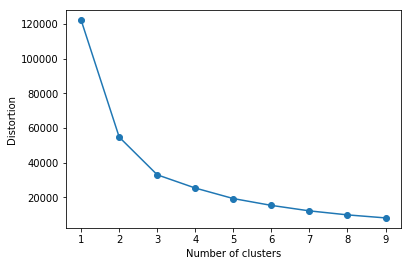

In [23]:
#choosing K using elbow method
def k_mean( df, kclusters = 5):
  kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(df)   # run k-means clustering
  return kmeans.labels_, kmeans.inertia_

distortions = []
for k in range(1,10):
  _ , sum_dist= k_mean(finaldf.drop('neighborhood',1),kclusters = k)
  distortions.append(sum_dist)

# elbow plot
plt.plot(range(1, 10), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

The number of clusters will be 4 (k=4)

In [31]:
k = 4     #according to the elbow plot
cluster_labels , _= k_mean(finaldf.drop('neighborhood',1),kclusters = k)
finaldf['cluster_labels'] = cluster_labels
#reorder the df
column_list = finaldf.columns.to_list()
old_idx = column_list.index('cluster_labels')
column_list.insert(1, column_list.pop(old_idx))
finaldf_clustered = finaldf[column_list]
finaldf_clustered

neighborhood  cluster_labels  Top Venue Restaurants  \
0                  Bath Beach               0                      3   
1                   Bay Ridge               2                      3   
2          Bedford Stuyvesant               0                      1   
3                 Bensonhurst               0                      3   
4                Bergen Beach               0                      3   
5                 Boerum Hill               3                      2   
6                Borough Park               0                      3   
7              Brighton Beach               0                      4   
8           Broadway Junction               3                      2   
9            Brooklyn Heights               2                      1   
10                Brownsville               0                      3   
11                   Bushwick               2                      3   
12                   Canarsie               0                      5   
13            Carroll Gardens               2                      3   
14                  City Line               0                      1   
15               Clinton Hill               2                      5   
16                Cobble Hill               3                      3   
17               Coney Island               0                      1   
18              Crown Heights               0                      0   
19              Cypress Hills               0                      2   
20                Ditmas Park               0                      2   
21                   Downtown               2                      3   
22                      Dumbo               2                      1   
23              Dyker Heights               0                      1   
24              East Flatbush               0                      3   
25              East New York               0                      3   
26          East Williamsburg               3                      1   
27                    Erasmus               3                      2   
28                   Flatbush               0                      2   
29                  Flatlands               0                      3   
30                Fort Greene               3                      2   
31              Fort Hamilton               2                      2   
32               Fulton Ferry               2                      1   
33                 Georgetown               0                      0   
34            Gerritsen Beach               0                      3   
35                    Gowanus               0                      1   
36                  Gravesend               0                      1   
37                 Greenpoint               2                      2   
38              Highland Park               0                      3   
39                  Homecrest               0                      2   
40                 Kensington               0                      2   
41                    Madison               0                      0   
42            Manhattan Beach               0                      0   
43          Manhattan Terrace               0                      2   
44                Marine Park               0                      1   
45                    Midwood               0                      2   
46                 Mill Basin               0                      2   
47                Mill Island               0                      0   
48                   New Lots               0                      2   
49                 North Side               1                      2   
50                 Ocean Hill               0                      3   
51              Ocean Parkway               0                      3   
52            Paerdegat Basin               0                      1   
53                 Park Slope               2                      3   
54           Prospect Heights               2            

## 4. Results

Results section where you discuss the results.

### Cluster 1

In [32]:
finaldf_clustered[finaldf_clustered['cluster_labels']==0] ## banyak yang belum punya restaurant (mostly under 10)

neighborhood  cluster_labels  Top Venue Restaurants  \
0                  Bath Beach               0                      3   
2          Bedford Stuyvesant               0                      1   
3                 Bensonhurst               0                      3   
4                Bergen Beach               0                      3   
6                Borough Park               0                      3   
7              Brighton Beach               0                      4   
10                Brownsville               0                      3   
12                   Canarsie               0                      5   
14                  City Line               0                      1   
17               Coney Island               0                      1   
18              Crown Heights               0                      0   
19              Cypress Hills               0                      2   
20                Ditmas Park               0                      2   
23              Dyker Heights               0                      1   
24              East Flatbush               0                      3   
25              East New York               0                      3   
28                   Flatbush               0                      2   
29                  Flatlands               0                      3   
33                 Georgetown               0                      0   
34            Gerritsen Beach               0                      3   
35                    Gowanus               0                      1   
36                  Gravesend               0                      1   
38              Highland Park               0                      3   
39                  Homecrest               0                      2   
40                 Kensington               0                      2   
41                    Madison               0                      0   
42            Manhattan Beach               0                      0   
43          Manhattan Terrace               0                      2   
44                Marine Park               0                      1   
45                    Midwood               0                      2   
46                 Mill Basin               0                      2   
47                Mill Island               0                      0   
48                   New Lots               0                      2   
50                 Ocean Hill               0                      3   
51              Ocean Parkway               0                      3   
52            Paerdegat Basin               0                      1   
55  Prospect Lefferts Gardens               0                      4   
56        Prospect Park South               0                      4   
58             Remsen Village               0                      4   
59                      Rugby               0                      3   
60                   Sea Gate               0                      2   
61             Sheepshead Bay               0                      2   
63              Starrett City               0                      2   
64                Sunset Park               0                      2   
65               Vinegar Hill               0                      3   
66                 Weeksville               0                      2   
69                    Wingate               0                      1   

    Restaurant  Venues  Restaurant_Ratio  Average_Rating  Average_Tips  
0            9      21          0.428571        3.722222      2.888889  
2            1      13          0.076923        7.800000      4.000000  
3            7      15          0.466667        2.171429      4.428571  
4            0       5          0.000000        0.000000      0.000000  
6            3      11          0.272727        4.333333      4.000000  
7           14      34          0.411765        6.992857     17.285714  
10           5      15          0.333333        2

### Cluster 2

In [33]:
finaldf_clustered[finaldf_clustered['cluster_labels']==1] ## restaurant rati0 0.2 ish, average rating 8

neighborhood  cluster_labels  Top Venue Restaurants  Restaurant  Venues  \
49   North Side               1                      2          23     100   
62   South Side               1                      3          27      94   

    Restaurant_Ratio  Average_Rating  Average_Tips  
49          0.230000        8.617391    149.173913  
62          0.287234        8.033333     77.851852

### Cluster 3

In [34]:
finaldf_clustered[finaldf_clustered['cluster_labels']==2] # top venue restaurant 1 - 3 # low number of tips (all <50)

neighborhood  cluster_labels  Top Venue Restaurants  Restaurant  \
1          Bay Ridge               2                      3          18   
9   Brooklyn Heights               2                      1          17   
11          Bushwick               2                      3          15   
13   Carroll Gardens               2                      3          21   
15      Clinton Hill               2                      5          24   
21          Downtown               2                      3          31   
22             Dumbo               2                      1          10   
31     Fort Hamilton               2                      2          13   
32      Fulton Ferry               2                      1          11   
37        Greenpoint               2                      2          18   
53        Park Slope               2                      3           8   
54  Prospect Heights               2                      2          21   
68   Windsor Terrace               2                      2          10   

    Venues  Restaurant_Ratio  Average_Rating  Average_Tips  
1       51          0.352941        6.383333     11.055556  
9       78          0.217949        6.947059     29.000000  
11      43          0.348837        7.566667     11.266667  
13      91          0.230769        7.571429     26.142857  
15      67          0.358209        6.866667     25.875000  
21      97          0.319588        7.306452     12.096774  
22      65          0.153846        5.860000     12.400000  
31      53          0.245283        7.492308     12.615385  
32      66          0.166667        7.527273     35.000000  
37      98          0.183673        7.561111     33.166667  
53      41          0.195122        7.937500     47.500000  
54      64          0.328125        8.242857     40.476190  
68      42          0.238095        6.590000     20.300000

### Cluster 4

In [35]:
finaldf_clustered[finaldf_clustered['cluster_labels']==3] ##average rating 7 - 8, average tips banyak, top venue restaurant 1 - 3, jumlah restaurat dikit

neighborhood  cluster_labels  Top Venue Restaurants  Restaurant  \
5         Boerum Hill               3                      2          12   
8   Broadway Junction               3                      2           1   
16        Cobble Hill               3                      3          14   
26  East Williamsburg               3                      1           7   
27            Erasmus               3                      2           4   
30        Fort Greene               3                      2          25   
57           Red Hook               3                      3           7   
67       Williamsburg               3                      2           5   

    Venues  Restaurant_Ratio  Average_Rating  Average_Tips  
5       46          0.260870        8.258333     74.000000  
8        7          0.142857        7.700000     73.000000  
16      43          0.325581        7.671429     61.785714  
26      55          0.127273        7.185714     67.000000  
27      25          0.160000        7.925000    104.000000  
30      59          0.423729        8.440000     73.480000  
57      37          0.189189        8.128571     85.142857  
67      26          0.192308        8.460000    121.200000

Let's Visualize our clistering result on the map. First, we add Latitude and Longitude of Neighborhood to our newly created finaldf_clustered and name it finaldf_viz

In [38]:
finaldf_viz = pd.merge(finaldf_clustered, brooklyn_data, left_on = 'neighborhood',right_on = 'Neighborhood')
finaldf_viz

neighborhood  cluster_labels  Top Venue Restaurants  \
0                  Bath Beach               0                      3   
1                   Bay Ridge               2                      3   
2          Bedford Stuyvesant               0                      1   
3                 Bensonhurst               0                      3   
4                Bergen Beach               0                      3   
5                 Boerum Hill               3                      2   
6                Borough Park               0                      3   
7              Brighton Beach               0                      4   
8           Broadway Junction               3                      2   
9            Brooklyn Heights               2                      1   
10                Brownsville               0                      3   
11                   Bushwick               2                      3   
12                   Canarsie               0                      5   
13            Carroll Gardens               2                      3   
14                  City Line               0                      1   
15               Clinton Hill               2                      5   
16                Cobble Hill               3                      3   
17               Coney Island               0                      1   
18              Crown Heights               0                      0   
19              Cypress Hills               0                      2   
20                Ditmas Park               0                      2   
21                   Downtown               2                      3   
22                      Dumbo               2                      1   
23              Dyker Heights               0                      1   
24              East Flatbush               0                      3   
25              East New York               0                      3   
26          East Williamsburg               3                      1   
27                    Erasmus               3                      2   
28                   Flatbush               0                      2   
29                  Flatlands               0                      3   
30                Fort Greene               3                      2   
31              Fort Hamilton               2                      2   
32               Fulton Ferry               2                      1   
33                 Georgetown               0                      0   
34            Gerritsen Beach               0                      3   
35                    Gowanus               0                      1   
36                  Gravesend               0                      1   
37                 Greenpoint               2                      2   
38              Highland Park               0                      3   
39                  Homecrest               0                      2   
40                 Kensington               0                      2   
41                    Madison               0                      0   
42            Manhattan Beach               0                      0   
43          Manhattan Terrace               0                      2   
44                Marine Park               0                      1   
45                    Midwood               0                      2   
46                 Mill Basin               0                      2   
47                Mill Island               0                      0   
48                   New Lots               0                      2   
49                 North Side               1                      2   
50                 Ocean Hill               0                      3   
51              Ocean Parkway               0                      3   
52            Paerdegat Basin               0                      1   
53                 Park Slope               2                      3   
54           Prospect Heights               2            

In [41]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(finaldf_viz['Latitude'], finaldf_viz['Longitude'], finaldf_viz['neighborhood'], finaldf_viz['cluster_labels']):
    label = folium.Popup(str(poi) + ' | Cluster: ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Discussion

Let's get descriptive statistics for each clusters, to determine the characteristics of each clusters.

In [67]:
finaldf_clustered.groupby(['cluster_labels'],as_index=False).describe()

cluster_labels                                    Top Venue Restaurants  \
           count mean  std  min  25%  50%  75%  max                 count   
0           47.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0                  47.0   
1            2.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0                   2.0   
2           13.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0                  13.0   
3            8.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0                   8.0   

                                                 Restaurant             \
       mean       std  min   25%  50%   75%  max      count       mean   
0  2.127660  1.208970  0.0  1.00  2.0  3.00  5.0       47.0   2.914894   
1  2.500000  0.707107  2.0  2.25  2.5  2.75  3.0        2.0  25.000000   
2  2.384615  1.120897  1.0  2.00  2.0  3.00  5.0       13.0  16.692308   
3  2.125000  0.640870  1.0  2.00  2.0  2.25  3.0        8.0   9.375000   

                                           Venues                              \
        std   min    25%   50%   75%   max  count       mean        std   min   
0  2.865308   0.0   1.00   2.0   4.0  14.0   47.0  14.148936   9.791253   1.0   
1  2.828427  23.0  24.00  25.0  26.0  27.0    2.0  97.000000   4.242641  94.0   
2  6.536878   8.0  11.00  17.0  21.0  31.0   13.0  65.846154  20.173606  41.0   
3  7.576986   1.0   4.75   7.0  12.5  25.0    8.0  37.250000  17.277153   7.0   

                             Restaurant_Ratio                                \
     25%   50%    75%    max            count      mean       std       min   
0   6.50  11.0  22.00   36.0             47.0  0.197423  0.166777  0.000000   
1  95.50  97.0  98.50  100.0              2.0  0.258617  0.040471  0.230000   
2  51.00  65.0  78.00   98.0             13.0  0.256854  0.075040  0.153846   
3  25.75  40.0  48.25   59.0              8.0  0.227726  0.102617  0.127273   

                                          Average_Rating                      \
        25%       50%       75%       max          count      mean       std   
0  0.061189  0.185185  0.279221  0.666667           47.0  3.898816  3.252828   
1  0.244309  0.258617  0.272926  0.287234            2.0  8.325362  0.412991   
2  0.195122  0.238095  0.328125  0.358209           13.0  7.219435  0.660995   
3  0.155714  0.190748  0.277048  0.423729            8.0  7.971131  0.438902   

                                                    Average_Tips              \
        min       25%       50%       75%       max        count        mean   
0  0.000000  0.000000  3.722222  7.187500  8.750000         47.0    7.333122   
1  8.033333  8.179348  8.325362  8.471377  8.617391          2.0  113.512882   
2  5.860000  6.866667  7.492308  7.566667  8.242857         13.0   24.376546   
3  7.185714  7.692857  8.026786  8.303750  8.460000          8.0   82.451071   

                                                                        
         std        min        25%         50%         75%         max  
0  10.280345   0.000000   0.000000    3.000000   10.333333   43.000000  
1  50.432313  77.851852  95.682367  113.512882  131.343398  149.173913  
2  12.278876  11.055556  12.400000   25.875000   33.166667   47.500000  
3  20.284046  61.785714  71.500000   73.740000   89.857143  121.200000

In [68]:
finaldf_clustered.groupby(['cluster_labels'],as_index=False).describe()['Top Venue Restaurants']

count      mean       std  min   25%  50%   75%  max
0   47.0  2.127660  1.208970  0.0  1.00  2.0  3.00  5.0
1    2.0  2.500000  0.707107  2.0  2.25  2.5  2.75  3.0
2   13.0  2.384615  1.120897  1.0  2.00  2.0  3.00  5.0
3    8.0  2.125000  0.640870  1.0  2.00  2.0  2.25  3.0

We need to analyze descriptive statistics for each column, starting with Top Venue Restaurants. There are no significant difference between each cluster.

In [69]:
finaldf_clustered.groupby(['cluster_labels'],as_index=False).describe()['Restaurant']

count       mean       std   min    25%   50%   75%   max
0   47.0   2.914894  2.865308   0.0   1.00   2.0   4.0  14.0
1    2.0  25.000000  2.828427  23.0  24.00  25.0  26.0  27.0
2   13.0  16.692308  6.536878   8.0  11.00  17.0  21.0  31.0
3    8.0   9.375000  7.576986   1.0   4.75   7.0  12.5  25.0

From this table we can conclude that Cluster 1 have less Restaurant in its neighborhoods compared to other Cluster, with median of 25 and min of 0 restaurant. 

In [70]:
finaldf_clustered.groupby(['cluster_labels'],as_index=False).describe()['Venues']

count       mean        std   min    25%   50%    75%    max
0   47.0  14.148936   9.791253   1.0   6.50  11.0  22.00   36.0
1    2.0  97.000000   4.242641  94.0  95.50  97.0  98.50  100.0
2   13.0  65.846154  20.173606  41.0  51.00  65.0  78.00   98.0
3    8.0  37.250000  17.277153   7.0  25.75  40.0  48.25   59.0

Cluster 3 have high number venue in its Neighborhoods, with mean of 65 venues per neighborhoods.

In [71]:
finaldf_clustered.groupby(['cluster_labels'],as_index=False).describe()['Restaurant_Ratio']

count      mean       std       min       25%       50%       75%       max
0   47.0  0.197423  0.166777  0.000000  0.061189  0.185185  0.279221  0.666667
1    2.0  0.258617  0.040471  0.230000  0.244309  0.258617  0.272926  0.287234
2   13.0  0.256854  0.075040  0.153846  0.195122  0.238095  0.328125  0.358209
3    8.0  0.227726  0.102617  0.127273  0.155714  0.190748  0.277048  0.423729

Cluster 2 have higher Restaurant_Ratio while Cluster 1 is the lowest.

In [72]:
finaldf_clustered.groupby(['cluster_labels'],as_index=False).describe()['Average_Rating']

count      mean       std       min       25%       50%       75%       max
0   47.0  3.898816  3.252828  0.000000  0.000000  3.722222  7.187500  8.750000
1    2.0  8.325362  0.412991  8.033333  8.179348  8.325362  8.471377  8.617391
2   13.0  7.219435  0.660995  5.860000  6.866667  7.492308  7.566667  8.242857
3    8.0  7.971131  0.438902  7.185714  7.692857  8.026786  8.303750  8.460000

Cluster 1 have poor rating in its neighborhoods, with median of only 3.72 rating per restaurant. This also contributed by less number of restaurant in its neighborhoods.

In [74]:
finaldf_clustered.groupby(['cluster_labels'],as_index=False).describe()['Average_Tips']

count        mean        std        min        25%         50%         75%  \
0   47.0    7.333122  10.280345   0.000000   0.000000    3.000000   10.333333   
1    2.0  113.512882  50.432313  77.851852  95.682367  113.512882  131.343398   
2   13.0   24.376546  12.278876  11.055556  12.400000   25.875000   33.166667   
3    8.0   82.451071  20.284046  61.785714  71.500000   73.740000   89.857143   

          max  
0   43.000000  
1  149.173913  
2   47.500000  
3  121.200000

Average_Tips column shows that cluster 4 has moderately high average tips given in Foursquare, which means more people come to the place and give tips for venues in cluster 4, cluster 1 have the lowest

From the analysis above we can conclude the characteristics for each neighborhood cluster:
1. Cluster 1: Lowest # of restaurant, Lowest restaurant ratio, Lowest average tips
2. Cluster 2: Highest restaurant ratio
3. Cluster 3: Higher number of Venues
4. Cluster 4: Higher number of tips

As a business owner that just recently start the business, we want to build our restaurant in places with less restaurant. This strategy is chosen because we want to grab smaller markets first with less competition. As we already have nice brand awareness later, we will expand our business to a more contested neighborhoods. The neighborhoods of our choice is shown below. As you can see, most neighborhoods located mostly in Souther/Central part of Brooklyn (colored red).

In [75]:
map_clusters

## 6. Conclusion

Conclusion section where you conclude the report.

According to the final map shown in 5.Discussion section, Cluster 1 have a high potential to be neighborhoods to start our first restaurant. Those neighborhoods are as follows.

In [77]:
finaldf_clustered[finaldf_clustered['cluster_labels']==0]['neighborhood']

0                    Bath Beach
2            Bedford Stuyvesant
3                   Bensonhurst
4                  Bergen Beach
6                  Borough Park
7                Brighton Beach
10                  Brownsville
12                     Canarsie
14                    City Line
17                 Coney Island
18                Crown Heights
19                Cypress Hills
20                  Ditmas Park
23                Dyker Heights
24                East Flatbush
25                East New York
28                     Flatbush
29                    Flatlands
33                   Georgetown
34              Gerritsen Beach
35                      Gowanus
36                    Gravesend
38                Highland Park
39                    Homecrest
40                   Kensington
41                      Madison
42              Manhattan Beach
43            Manhattan Terrace
44                  Marine Park
45                      Midwood
46                   Mill Basin
47      